# Assignment 2

### Import

In [350]:
import urllib2
import json
import re
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import collections
import numpy as np
from collections import Counter
from collections import defaultdict
from __future__ import division
import io
import sys
import operator
from math import log10, floor
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import timeit
from scipy import spatial
from sklearn.feature_extraction.text import TfidfVectorizer
import os

# Function used to round numbers to n significant numbers
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

# Part I: Comunity Structure

** Explain the concept of modularity in your own words. ** 

**Modularity** is a measurement that allows us to quantify the goodness of a partition of a network into communities, where partition is a division of a network into an arbitrary number of groups such that each node belongs to one and only one group. More specifically, Modularity is a concept that measures systematic deviations from a random configuration of a network. This helps us indentifying groups that are embedded in a network, and finding nodes that interact more frequantly with each other than in a random network. Therefore modularity is simply a measurement of the systematic deviations from a random configuration. Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules

The modularity of a network can be calculated with the following equation

Equation 9.12

$$ M_c = \sum_{c=1}^{n_c}[ \dfrac{L_c}{L} - (\dfrac{k_c}{2L}) ] $$

where:

    * L : total number of links in the network
    * Lc = number of links in each community 
    * kc = total degree of the nodes

Note that kc is the total degree of the nodes in the graph but lc is the number of links withing the subgraph that the community creates. Therefore we do not count edges that goes between communities for lc.  


** Now, calculate the modularity of the branches reported by the Wikipedia editors **

We start by creating a dictionary that contains the names of all philosophers in the each branch of philosophy

In [139]:
philosophers = {
    "aestheticians":{ "title":"title=List_of_aestheticians", "names":""},
    "epistemologists":{ "title":"title=List_of_epistemologists", "names":""},
    "ethicists":{ "title":"title=List_of_ethicists", "names":"" },
    "logicians":{ "title":"title=List_of_logicians", "names":"" },
    "metaphysicians":{ "title":"title=List_of_metaphysicians", "names":"" },
    "social and political philosophers":{ "title":"title=Index_of_sociopolitical_thinkers", "names":""}
}

We then loop through each branch's wikipage and collect the names of the philosophers

In [146]:
# set the parameters (explained in detail here https://www.mediawiki.org/wiki/API:Tutorial)
baseurl = "https://en.wikipedia.org/w/index.php?"
title = ""
action = "action=edit"

for i in philosophers:
    # construct the query
    query = "{}{}&{}".format(
        baseurl,
        philosophers[i]["title"],
        action
    )
    
    # use urllib and regex to get the list of philosophers
    wikiresponse = urllib2.urlopen(query)
    wikisource = wikiresponse.read()
    philosophers[i]["names"] = re.findall(r'\*.*?\[\[(.*?)[\]\|]', wikisource)

# Because the last 4 elements of the ethicists list and social and political philosophers are not philosophers
# they are left out
philosophers["ethicists"]["names"] = philosophers["ethicists"]["names"][:-4]
philosophers["social and political philosophers"]["names"] = philosophers["social and political philosophers"]["names"][:-4] 

Then we loop through each philosopher's wikipage and in each page we find the links to other philosophers. From that information we create the undirected graph

In [147]:
G = nx.Graph() # Create a undirected graph

# First of all get all the philosophers
all_philophers = []
for i in philosophers:
    all_philophers = all_philophers + philosophers[i]["names"]

all_philosophers_uniq = set(all_philophers)
    
counter = 0

# set the parameters for the query (explained in detail here https://www.mediawiki.org/wiki/API:Tutorial)
baseurl = "https://en.wikipedia.org/w/api.php?"
actions = "action=query"
title = "titles="
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

# iterate through the philosophers and for each philosphers download his wikipedia page
# The list comprehension goes through the list of philosophers and replaces " " for "_"
for philo in all_philosophers_uniq:
    query = "{}{}&{}{}&{}&{}".format(
        baseurl,
        actions,
        title,
        philo.replace(" ","_"),
        content,
        dataformat
    )
    #print(philo)
    #print(query)
    
    wikiresponse = urllib2.urlopen(query)
    theArticle = wikiresponse.read()
    
    # Add the philosopher to the graph
    G.add_node(philo)

    # use regex and the set.intersection function to find all philosophers that are linked from the 
    # wikipage of each philosopher
    linkedPhilosophers = set(re.findall(r'.*?\[\[(.*?)[\]\|]', theArticle)).intersection(all_philosophers_uniq)

    # Go through all the linked philosophers and add directed edge for each one
    for linkedPhilosopher in linkedPhilosophers:
        G.add_edge(philo,linkedPhilosopher)

 ** Algorithm procedure: **
 
 - Our network has more than one component, So we need to get the giant connected component (GCC) of our network. We call it giant_G. 
 - Then we find the all of the philosophers in that network that are part of more than one branch (the overlapping_philo variable).
 - If the philosopher is not in two branches we add him to a list of tuple pairs (name,community), we call this list philo_community_list. Therefore at this time in the program this list contains all philosophers that are only associated with one community
 - The next step in our algorithm is to find a community for the philosophers that are in more than two branches (overlapping philosophers). The way we did it is that for each overlapping philosopher, we found all neighbours of that philosopher that are only in one branch (non overlapping neighbours). We then simply assigned the philosopher to the branch that most of his non overlapping neighbours are in, in other words we assigned the philosopher to the branch that he has most connections to. If the philosopher is not connected to any non overlapping philosopher then we simply chose a brand at random. **Note** We decided to only consider the non overlapping neighbor of the overlapping philosopher because it does not make sens to consider a neighbor that has not yet been assigned to a new branch by the rules of our algorithm  
 - Now philo_community_list contains all of the philosophers in the G_giant graph and each philosopher has been assigned to a branch
 - Then we simply changed the philo_community_list into a dictionary and calculated the modularity of the community division.



In [334]:
# Get the Giant connected component (GCC)
giant_G = max(nx.connected_component_subgraphs(G), key=len)

# Get all philosophers in the giant connected component
giant_all_philosophers = giant_G.nodes()

giant_philosophers_counted = []

# Find all philosophers that appear in more than one list
for branch in philosophers.keys():
    for philo in philosophers[branch]["names"]:
        if philo in giant_all_philosophers:
            giant_philosophers_counted.append(philo)
            
giant_philosohers_counted = Counter(giant_philosophers_counted)

# The next step is to find all of the philosophers that are part of more than one branch
overlapping_philo =[philo for philo,value in giant_philosohers_counted.items() if value > 1]

# create the communities dictionary for the philosophers
philosophers_communities = {
    "aestheticians" : [],
    "epistemologists" : [],
    "ethicists" : [],
    "logicians" : [],
    "metaphysicians" : [],
    "social and political philosophers" : []
}

# Now we create a list of tuple pairs (name,community) that contain all philosophers that only appear in one list
philo_community_list = []
for community in philosophers_communities.keys():
    for name in philosophers[community]["names"]:
        # Add the philosopher if he is not overlapping 
        if name in giant_all_philosophers:
            if name not in overlapping_philo:
                philo_community_list.append((name,community))
                

# Now we go through the list of overlapping philosophers and add them to the list with a assigned community
philo_community_list_overlapping = [] # temp list that contains the added overlapping philos
for philo in overlapping_philo:
    # next we find the non overlapping neighbours of each overlapping philo.  
    neighbors = [neighbor for neighbor in philo_community_list if neighbor[0] in giant_G.neighbors(philo)]
    community = ""
    if neighbors: # check if neighbours is not an empty list
        # find the most common community
        neighbors_communities = Counter(neighbor_tuple[1] for neighbor_tuple in neighbors)
        community = max(neighbors_communities.items())
        # Check if there are communities that are equals if so then choose randomly from them
        community = np.random.choice([k for k, v in neighbors_communities.items() if v == community[1]])
    else:
        # in case of no neighbour we choose the community by random
        community = np.random.choice(["aestheticians","epistemologists","ethicists","logicians","metaphysicians","social and political philosophers"])
    
    # Add the phylosopher to the philo_community_list
    philo_community_list_overlapping.append((philo,community))

# Add the newly assingd overlapping philosophers to the philo_community_list
philo_community_list = philo_community_list + philo_community_list_overlapping

# We end by adding the philosophers into their communities in a dictionary
for philo in philo_community_list:
    philosophers_communities[philo[1]].append(philo[0])

Now every philosopher in the giant component of our graph has been assigned to a branch. Therefore the division of the philosophers into a communities is done and we can calculate the modularity.

In [347]:
# Then we loop throught the communities and calculate the modularity (Mc) for each community
modularity = []
L = len(giant_G.edges()) # L : total number of links in the network
for community in philosophers_communities.keys():
    sub_graph = giant_G.subgraph(philosophers_communities[community]) # Create a subgraph for the community
    Lc = len(sub_graph.edges()) # Total number of edges in the community
    kc = sum([giant_G.degree(philo)  # Get the total degrees of the nodes in the community
              for philo in philosophers_communities[community]]) 
    M = (Lc/L)-((kc/(2*L))**2) # calculate the modularity for the community with equation 9.12
    modularity.append(M)

"The modularity is:    {}".format(sum(modularity))

'The modularity is:    0.159345865933'

** Comment on your value of $M$ for the branches. Are the branches good communities? **

We got the value of modularity as ~0.1593, but bare in mind there is a random factor in our algorithm so the result might vary a littlebit in each iteration but not much. As stated in Network Science in Chapter 9 there are several key properties to modularity. You can have a negative value of modularity which occurres if we assign each node to a different community. Modularity of zero means that we take the whole network as a single community. Modularity can not go above 1 but the higher it is for a specific partition of the network, the better is the corresponding community structure. There are examples of optimal and suboptimal partitions in the book for a specific network. There the optimal modularity is 0.41 but the sup optimal modularity has the value 0.22. This gives us an idea of how good our partitioning is but to fully understand it we need to find the modularity of the optimal partitioning of the G_giant graph

**Now, let us use the Python Louvain-algorithm implementation to find communities in the full philosopher network **


In [338]:
import community
import networkx as nx
import matplotlib.pyplot as plt


# First compute the best partition
partition_giant = community.best_partition(giant_G)
partition_full = community.best_partition(G)

# Find how many communities there are in the partition 
communities_giant = Counter([value for key,value in partition_giant.items()])
communities_full = Counter([value for key,value in partition_full.items()])

print "The full philosophy network is split up to {} communities".format(len(communities_full))
print "The modularity of this community division is {}".format(
    community.modularity(partition_full,G)
)

print "" 

print "The giant component of the philosophy network is split up to {} communities".format(len(communities))
print "The modularity of this community division is {}".format(
    community.modularity(partition_giant,giant_G)
)


The full philosophy network is split up to 210 communities
The modularity of this community division is 0.454005049928

The giant component of the philosophy network is split up to 12 communities
The modularity of this community division is 0.455676160125


__Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the branches as communities? What does this comparison reveal about the branches?
__

The **full network** is not a complete graph. The giant component of that graph contains 838 nodes but the full network contains 1047 nodes. To understand the behavior better we plotted up both the full network and the giant component. We colored the nodes based on the community that they are assigned to. What the plot reveals is thet there are many philosophers that are not connected to any other philosophers. What the algorithm most likely does for the full network is that it creates many communities which contains very few nodes(philosophers) in the graph and then it devides the giant component up to three communities. We did not consider it to be relevant to focus more on the full network because in our algorithm we are only dividing the giant component up to communities and calculating the modularity based on that division. Therefore we will only focus on the giant component in the following analysis

The optimal partition of our giant component partitiones the network into 12 communities. This division results in a modularity of 0.45401. Our algorithm is dividing the community into 6 communities, one for each brand. That division resulted in a modularity of ~0.1593 which is quite far away from the optimal modularity value for the graph but it is much higher than zero. Therefore we can safely concluded that the partitioning is sub optimal but not nearly optimal. We are dividing the giant component into fewer communities but still resulting in a division wich is much higher than zero, therefore it is a better division than just assigning all nodes to the same community. 

**Conclusion:** This reveals that the branches division is quite good community division but not nearly optimal.

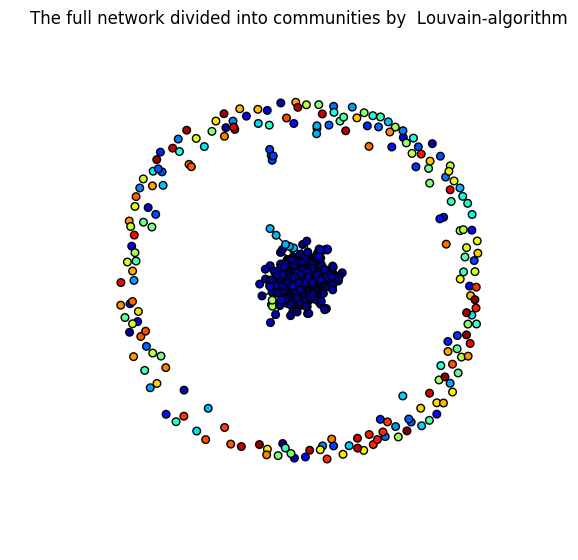

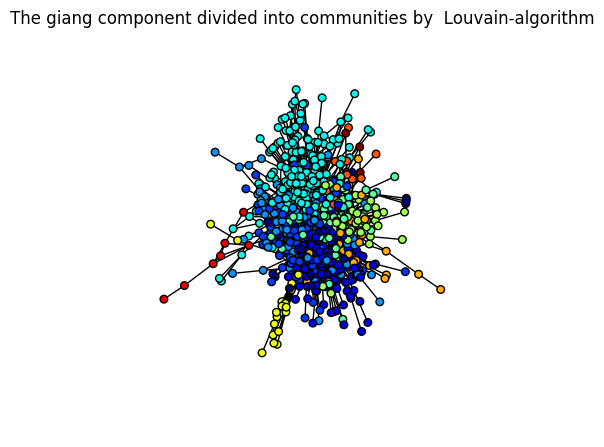

In [346]:
# to get an idea about the partition we plot it with colours representing each community:
# the full network divided by the Louvain-algorithm
plt.figure(figsize=(5,5))
values = [partition_full.get(node) for node in G.nodes()]
nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)
plt.title('The full network divided into communities by  Louvain-algorithm')
plt.show()

# The giant component divided by the Louvain-algorithm
plt.figure(figsize=(5,5))
values = [partition_giant.get(node) for node in giant_G.nodes()]
plt.title('The giang component divided into communities by  Louvain-algorithm')
nx.draw_spring(giant_G, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)
plt.show()


** Compare the communities found by your algorithm with the branches (that you analyzed abo ve) by creating a matrix D with dimension ($B$ times $C$), where $B$ is the number of branches and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that branch $i$ has in common with community $j$. The matrix D is what we call a confusion matrix. Use the confusion matrix to explain how well the communities you've detected correspond to the labeled branches of philosophy. ** 

In [348]:
import numpy as np

# We start by creating a 6*12 matrix

# Remember that partition_giant contains the optimal division of the algorithm
# and philosophers_communities contains our community algorithm division of the philosophers.

B = 6 # number of branches
C = 12 # number of communities in the optimal solution

confusion_matrix = np.empty((B,C,))
confusion_matrix[:] = 0

#Let's loop through our branches
for i,branch in enumerate(philosophers_communities.keys()):
    #Loop through our philosophers from the community.best_partition algorithm
    for philosopher in partition_giant:
        #We then check if said philosopher is in said branch
        if philosopher in philosophers_communities[branch]:
            #If that is the case we increment the value of the matrix at [branch,community number] position
            confusion_matrix[i,partition_giant[philosopher]] += 1 

print confusion_matrix

[[  14.  111.   25.   22.   10.   25.   41.   12.   22.    0.    0.    2.]
 [  11.   21.    7.   13.    3.    7.    1.    0.   14.    0.    0.    0.]
 [   8.    1.   38.    4.  135.    5.    0.    1.    6.   10.    7.    0.]
 [   2.    5.    6.   16.    7.    2.    5.    0.    1.    0.    0.    2.]
 [   2.    8.   19.   11.   16.    1.    1.    0.    3.    0.    0.    0.]
 [   8.   20.   32.   42.    5.   28.    5.    6.    8.    1.    0.    0.]]


# Part II: Human navigation paths

## IIa: Path lengths

The first thing we want to take a look at is path lengths. NetworkX allows us to calculate the shortest path between any pair of articles. We begin by comparing the length of human and shortests paths.

### Exercise

** For each source/target pair in the list of human navigation paths, calculate the shortest path using NetworkX. Plot the distribution of path lengths**


We decided to use undirected graph. We start of by creating a undirected graph from the links.tsv file. We simply run through the file line by line. For each line (except the first 12 lines which only contain information about the dataset) we add an edge to the graph.

In [353]:
# Read in the links.tsv file
file_path = '/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/wikispeedia_paths-and-graph/links.tsv'

G = nx.Graph()

with io.open(file_path, encoding="utf-8") as f:
    lines = f.readlines()
    lines = lines[12:]
    for line in lines:
            line = line.split()
            G.add_edge(line[0],line[1])            
print("number of nodes: {}".format(len(G.nodes())))
print("number of edges: {}".format(len(G.edges())))

number of nodes: 4592
number of edges: 106647


The next step is to go through the finished paths and get each source target pair

In [367]:
# container that contain the tuple pairs (source, target, length of path)
human_navigation_paths = []

# Read in the links.tsv file
file_path = '/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/wikispeedia_paths-and-graph/paths_finished.tsv'

G_humanpaths = nx.Graph()
paths = [] # container for all the completed human paths

with io.open(file_path, encoding="utf-8") as f:
    lines = f.readlines()
    lines = lines[16:] # Take out the lines that are not links
    for line in lines:
        line = line.split()[3] # Get the path from the line
        line = line.replace(";<","") # Back clicks are represented as "<", here we delete them from the path
        line = line.split(";") # split the path on ; to get an array of websites
        G_humanpaths.add_path(line) # add the path to the human path graph
        paths.append(line)
        source = line[0] # find the source website
        target = line[-1] # find the target website
        
        # note that we take the length of the path as the number of nodes in the path - 1 
        # we subtract one as the edges are one less than the nodes
        human_navigation_paths.append((source,target,len(line)-1)) # add the tuple (source, target, length of path)  

Now everything is ready to calculate the shortest path between each source target pair. The reason for the try and catch block is that the node "Wikipedia_Text_of_the_GNU_Free_Documentation_License" is not part of the links list and therefore it is not in our graph. This is most likely just a minor error in the dataset

In [368]:
# Container for the shortest path for each source/target pair. Contains the tuple (source, target, shortest path length)
shortest_paths = []    

for source,target,_ in human_navigation_paths:
    try:
        shortest_paths.append( 
            (
                source,
                target,
                nx.shortest_path_length(G,source=source,target=target)
            )
        )
    except:
        print ("Unexpected error:", sys.exc_info()[0])
        print("target : {}".format(target))
        print("source : {}".format(source))
            

('Unexpected error:', <class 'networkx.exception.NetworkXError'>)
target : Wikipedia_Text_of_the_GNU_Free_Documentation_License
source : Bird


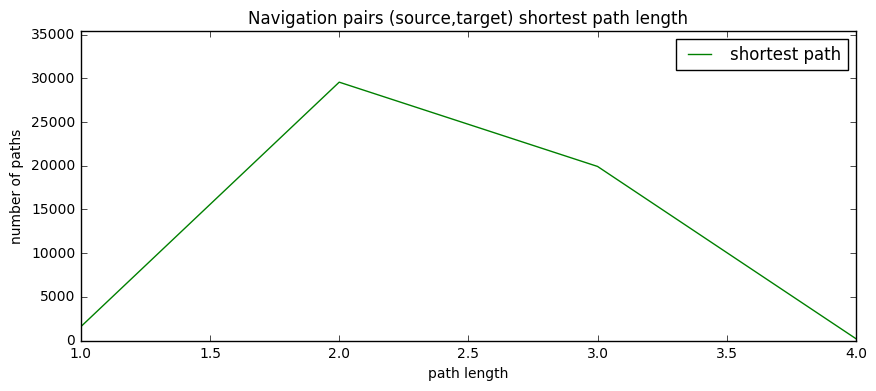

In [378]:
# Get the length of the shortest paths
shortest_path_lengths = [length for source, target, length in shortest_paths]

# plot the distribution
plt.figure(figsize=(10,4))
plt.plot(list(Counter(shortest_path_lengths).keys()), list(Counter(shortest_path_lengths).values()), color="green")
plt.xlim((1, 4))
plt.ylim(0,max(list(Counter(shortest_path_lengths).values()))*1.2)
plt.title("Navigation pairs (source,target) shortest path length")
plt.xlabel("path length")
plt.ylabel("number of paths")
plt.legend(["shortest path"])
plt.show()

 - From this graph it can be seen that most of the target websited can be reached in only 3 clicks or fewer, from a given source. 
 - For each (source,target) pair in the game it is possible to complete the game in only 4 clicks
 
 This will gives us the foundation to evaluate the lenght of the human paths. We now know that for each target/source assignment the human should be able to finish the assignment in no more than 4 clicks. But we also know that he needs to be both lucky and quite bright to do so :). 
 
 This corresponds well to the small world phenomenon, which states that if you choose any two individuals anywhere on Earth, you will find a path of at most six acquaintances between them. This is do to the fact that the network contains hubs that have high centrality betweenness (large wikipages that have many links) and can therefore act as a gateway connecting the source and the target websites.

** For each source/target pair, calculate the length of the human path. The dataset contains information on people who regret a navigation step and hit the "back" button in their web-browser. It's up to you how to incorporate that information in the path. Justify your choice. Plot the distribution of human path lengths**
 
*We decided to just **remove** the back icon (<) from the human navigation paths*

**Justification**:

- We decided to only count the clicks on the wikipedia links, therefore we simply removed the back icon from each path. One of the reasons why we did that is that the graph we use is undirected and a link 'back' is the same as a link 'forward' and therefore we don't count the 'backs'.

- Another reason is that the breadth first search algorithm uses backs when finding the shortest path in a graph but does not count it.  Therefore, we think it is only fair that the human's can enjoy the same benefits. For more information on breadth first search click this [link](http://barabasi.com/networksciencebook/) and navigate to the chapter two of the book.



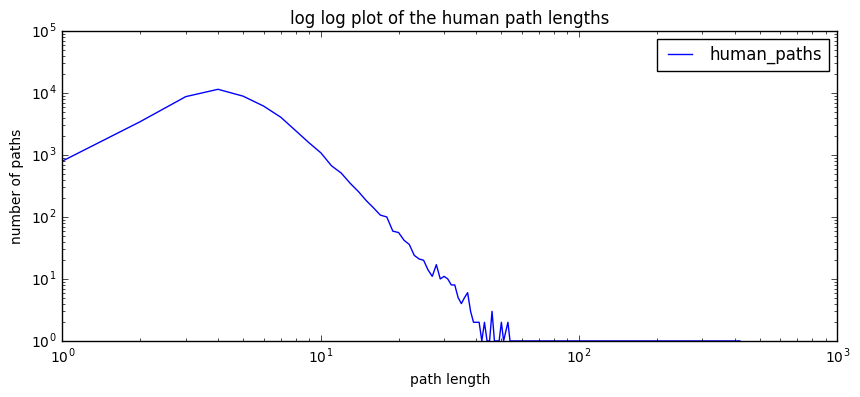

The mean value of the human path length is:     5.357
The median value of the human path length is:   5.0
Percentage of paths of length 6 or less is:     0.7686


In [399]:
keys, values = zip(*sorted(Counter([length for target,source,length in human_navigation_paths]).items(), 
                              key = operator.itemgetter(0)))

plt.figure(figsize=(10,4))
plt.plot(keys, values)
plt.xscale("log")
plt.yscale("log")
plt.title("log log plot of the human path lengths")
plt.xlabel("path length")
plt.ylabel("number of paths")
plt.legend(["human_paths"])
plt.show()


# Find the mean and the median values for the human navigation lengths
print ("The mean value of the human path length is:     {}").format(
    round_sig(np.mean([length for target,source,length in human_navigation_paths]),4)
)
print ("The median value of the human path length is:   {}").format(
    np.median([length for target,source,length in human_navigation_paths])
)


# We decided to do some extra work and find the % of the paths that er higher than 6
all_nums = [x[2] for x in human_navigation_paths]

num_under_6 = len([x for x in all_nums if x <= 6])
num_over_6 = len([x for x in all_nums if x > 6])

print "Percentage of paths of length 6 or less is:     " + str(round_sig(
    num_under_6/(len(human_navigation_paths)),
    4
))




Looking at the distribution it can be seen that most of the human navigation paths lengths fall around the value 4, which is surprisingly good. The distribution is skewed and there are some clear outliers in the distribution. It is interesting to see that the maximum human navigation path length is 419. Another interesting thing to notice is that 76.9% of the path lengths are smaller or equal to 6, which is in compliance with the small world phenomenon.

** How much longer are the human paths on average? **

In [392]:
human_path_avg = np.mean([length for target,source,length in human_navigation_paths])
shortest_path_avg = np.mean([length for source, target, length in shortest_paths])

print("The human paths average is           {}".format(round_sig(human_path_avg,4) ))
print("The shorest paths average is         {}".format(round_sig(shortest_path_avg,4) ))
print("-------------------------------------------")
print("The difference is                    {}".format(round_sig(human_path_avg - shortest_path_avg,4)))

The human paths average is           5.357
The shorest paths average is         2.365
-------------------------------------------
The difference is                    2.992


Here it has to be taken into the account that there are some clear outliers in the human navigation path lengths which influance the mean value. The median value of the human navigation path lengths is 5 which is more representative of distribution.

** Create scatter plot where each point is a source/target pair, and you have human path lengths on the x-axis and shortests paths on the y-axis. **

We start of by creating two dictionaries. One that contains the shortest path length of every source/target pair. And another that contains every human path length for each source/target pair

In [372]:
shortest_path_dict = defaultdict(set)
human_navigation_path_dict = defaultdict(list)

# get values into the shortest path dictionary
for source, target, length in shortest_paths:
    shortest_path_dict[(source, target)].add(length)

# get values into the human path dictionary
for source, target, length in human_navigation_paths:
    human_navigation_path_dict[(source, target)].append(length)
    
# create a list of tuples of the form (shortest path, human path)
shortest_vs_human = []
for source, target in shortest_path_dict.keys():
    for human_length in human_navigation_path_dict[(source, target)]:
        shortest_vs_human.append(( list(shortest_path_dict[(source,target)])[0], human_length))

Now we have all of the information we need to plot each human path lenght source/target pair point against the shortest path value for that specific source/target pair

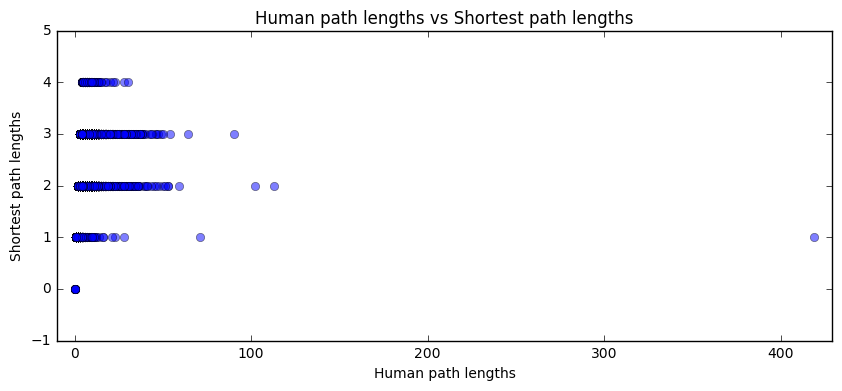

In [400]:
# Create the plot

# We start by reverse ziping the shortest_vs_human tuples array
y,x = zip(*shortest_vs_human)

# The we plot the result
plt.figure(figsize=(10,4))
plt.plot(x, y, "o", alpha=0.5)
plt.xlim(-10, max(x)+10)
plt.ylim(-1, max(y)+1)
plt.title("Human path lengths vs Shortest path lengths")
plt.xlabel("Human path lengths")
plt.ylabel("Shortest path lengths")
plt.show()

Here the outlier can be seen quite well. This individual should have been able to finish the taks in one click but he manage to use 419 clicks, which is quite impressive. Another interesting thing to notice is that the outliers are not correlated with the shortest paths. You would think that most of the longer human paths would be where the shortest path has a value of 4, which is not the case. 

** Is there a correlation between human/shortest path-lengths? What is the correlation. **

You can clearly see on the figure here above that there is no correlation between human/shortest path-lengths. This can investigated further by using the numpy module to calculate the correlation between x and y. The code to accomplish this can be seen here below. The result was that the correlation between x and y is 0.20678837 which supporst the hypothesis that the human/shortest path-lengths are not correlated.

In [377]:
np.corrcoef(x,y)

array([[ 1.        ,  0.20678837],
       [ 0.20678837,  1.        ]])

## IIb: Betweenness

** Navigation centrality :** Navigation centrality of node i is the fraction of all naviagtion paths that pass through i. We exclude the source and target from the count. If a node has not been visited by a search, the navigation centrality of that node is defined to be zero.

## Exercise

** Begin by calculating the betweenness centrality and navigation centrality of all nodes in the wikispedia dataset. Note that calculating the betweenness centrality can take quite a long time, so you might start it running in a separate notebook while first estimating it based on the existing human path.**

** First, list the 5 pages with highest navigation centrality.**

Calculate the navigation centrality for each node/website

In [404]:
navigation = defaultdict(float) # contains the navigation score for each website
nr_of_paths = len(paths) 

# For each website we go through every path in the paths_finished file
# and we count how many times the website is in a path (not source nor target)
for website in G.nodes():
    freq = 0
    for path in paths:
        path = path[1:-1] # Deleting the source and the target from the path 
        if website in path:
            freq += 1
    navigation[website] = freq/nr_of_paths

Print out the top five websites

In [409]:
navigation_sorted = sorted(navigation.items(), key=operator.itemgetter(1), reverse=True)

# print out the list of the 5 pages that have the highest centrality :)
print ("{webpage_s: <26} {centrality_d: <14}".format(
            webpage_s = "Website:", centrality_d = "Navigation centrality value:"
        ))

print("-------------------------------------------------------")

for page, centrality in navigation_sorted[:5]:
    print ("{webpage_s: <26} {centrality_d: <14}".format(
            webpage_s = page, centrality_d = round_sig(centrality,5)
        ))

Website:                   Navigation centrality value:
-------------------------------------------------------
United_States              0.16766       
Europe                     0.083012      
United_Kingdom             0.073327      
Earth                      0.060525      
England                    0.059472      


** Second, list the 5 pages with highest betweenness centrality. **

In [411]:
betweenness = nx.betweenness_centrality(G) # calculate the betweenness of the network

print out the top five websites

In [413]:
betweenness_sorted = sorted(betweenness.items(), key=operator.itemgetter(1), reverse=True)

# print out the list of the 5 pages that have the highest centrality :)

print ("{webpage_s: <26} {centrality_d: <14}".format(
            webpage_s = "Website:", centrality_d = "Betweenness centrality value:"
        ))

print("-------------------------------------------------------")

for page, centrality in betweenness_sorted[:5]:
    print ("{webpage_s: <26} {centrality_d: <14}".format(
            webpage_s = page, centrality_d = round_sig(centrality,5)
        ))

Website:                   Betweenness centrality value:
-------------------------------------------------------
United_States              0.12522       
United_Kingdom             0.047387      
Europe                     0.044658      
France                     0.036809      
England                    0.033597      


** Compare the two lists. Explain the differences between the two lists in your own words. **

- Both lists have only locations as the highest values; countries, continents, and planets. 
- In both cases, the United States has by far the highest score. 
- The only pages that don't appear in both lists are France and Earth. 
- France contains more of the actual shortest paths while the human users click more on the link that contains the Earth-wikipedia page.

The lists are very similar because the player tries to find a hub in the network. In other words the player tries to find a wikipage that has links to many other websites as well as a broad spectrum of information. However these hubs may not neccesarily fall on the shortest path, thus they might have a lower betweenness.

In [418]:
# We will compare the two lists by finding how many item are the same in both lists
# the function prints out how many items are common in each list,
# it also prints out the common websites and the websites that are different in for each centrality

def compareCentralities(navigation_C, betweenness_C, n, p):
    navigation_subset = [website for website,_ in navigation_C[:n]]
    betweenness_subset = [website for website,_ in betweenness_C[:n]]
    
    intersection = [website for website in navigation_subset if website in betweenness_subset]
    
    if p == True:
        print ("The intersection between the two centralities for the top {} items are:".format(n))
        print ("---------------------------------------------------------------------")
        for i in intersection:
            print(i)
        
        print ("\nThe distinctive items in the navigation centrality for the top {} items are".format(n))
        print ("----------------------------------------------------------------------")
        for i in [website for website in navigation_subset if website not in intersection]:
            print(i)
            
        print ("\nThe distinctive items in the betweenness centrality for the top {} items are".format(n))
        print ("----------------------------------------------------------------------")
        for i in [website for website in betweenness_subset if website not in intersection]:
            print(i)
        
    # returns the fraction of intersection items between the two centralities
    #return len(intersection)/n

# let´s visualize the difference between these two centralities
compareCentralities(navigation_sorted, betweenness_sorted, 5, True)

The intersection between the two centralities for the top 5 items are:
---------------------------------------------------------------------
United_States
Europe
United_Kingdom
England

The distinctive items in the navigation centrality for the top 5 items are
----------------------------------------------------------------------
Earth

The distinctive items in the betweenness centrality for the top 5 items are
----------------------------------------------------------------------
France


** Create a scatterplot of betweenness centrality vs. navigation centrality.**

Here remember that A vs. B means that A = y axis, B = x axis

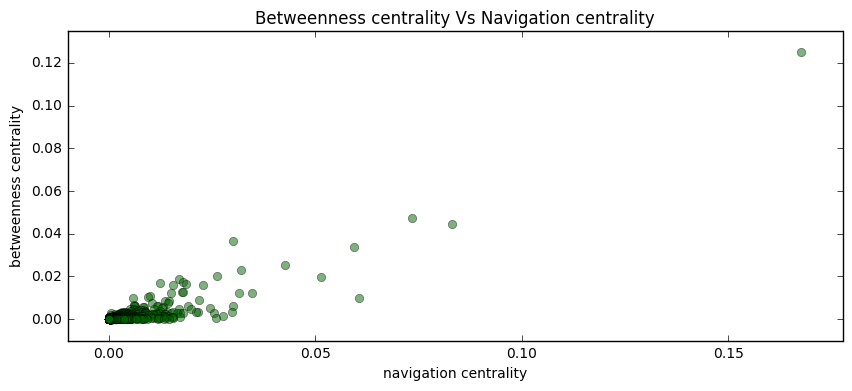

In [422]:
x = range(0,len(betweenness_sorted))
betweenness_values = [value for website,value in betweenness_sorted]
navigation_values = [navigation[website] for website,_ in betweenness_sorted]

plt.figure(figsize=(10,4))
plt.plot(navigation_values, betweenness_values, "o", color="darkgreen", alpha=0.5)
plt.title("Betweenness centrality Vs Navigation centrality")
plt.xlabel("navigation centrality")
plt.ylabel("betweenness centrality")
plt.xlim(-0.01,max(navigation_values)+0.01)
plt.ylim(-0.01,max(betweenness_values)+0.01)
plt.show()

Here it can be seen that there is a high corrlation (0.8886) between the betweenness centrality and the navigation centrality. Outliers in the Navigation centrality are also outliers in the betweenness centrality

In [423]:
np.corrcoef(betweenness_values,navigation_values)

array([[ 1.       ,  0.8886482],
       [ 0.8886482,  1.       ]])

**Let's explore the pages that have navigation centrality equal to zero.**

- How many pages have zero navigation centrality?
- What is the the page with zero navigation centrality and highest betweenness centrality? Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node).
- Plot the distribution of betweenness centrality for the pages with zero navigation centrality.

** How many pages have zero navigation centrality **

In [430]:
# Find all pages with zero navigation centrality
zero_navigation_centrality = [website for website,value in navigation_sorted if value == 0]

print("There are {} pages that have zero navigation centrality".format(len(zero_navigation_centrality)))
print(" -> that is {} percent of all websites ({} in total) in the dataset".format(
        round_sig((len(zero_navigation_centrality)/len(navigation_sorted))*100,3), len(navigation_sorted)
    ))

There are 1187 pages that have zero navigation centrality
 -> that is 25.8 percent of all websites (4592 in total) in the dataset


** What is the page with zero navigation centrality and highest betweenness centrality? Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node). **

The page is *[List of lakes](https://en.wikipedia.org/wiki/List_of_lakes)* which has the betweenness centrality value of 0.0009143. The degree of the page's corresponding node in the graphs is 109, which is interesting when you considere that the average degree in the graphs is 46.449. Initially this came as an surprise but after further investigation it all started to make sens. The *[List of lakes](https://en.wikipedia.org/wiki/List_of_lakes)* contains a list of lakes by country and therefore can be considered as a some sort of an gateway to wiki pages of the countries. In our earlier work we found out that countries have really high centrality value for both betweenness centrality and navigation centrality. A wikipage of a country is, in most cases, huge page which contain vast amount of information and links in it. Therefore each country's wikipedia page can be cosidered as a gateway (hub) to many different things conserning that country and it is therefore a great decision in the game to click on those pages. A lot of people that finished the game figured this out which can be seen by inspecting the navigation centrality values. However no one figured out that the list of lakes page was a good way to access the countries wikipedia pages which is understandable, at least initially I did not consider it to be a good strategy to click on this page. 

In [433]:
# Find the betweenness centrality value for the pages that have 0 navigation centrality
navigationZero_betweenness = [(website, betweenness[website]) for website in zero_navigation_centrality]

website, betweenness_value = max(navigationZero_betweenness,key=operator.itemgetter(1))

# Find the page with the highest betweenness centrality
print ("The page with zero navigation centrality and highest betweenness centrality is: \n  '{}'".format(
    website
))
print ("  -> with betweenness centrality value of: {}".format(
    round_sig(betweenness_value,4)
))

print ("\nThe degree of the node '{}' in the graph is: {}. \nThe average degree in the graph is {}".format(
        website,
        G.degree(website),
        round_sig(np.mean(list(G.degree().values())),6)
    ))

The page with zero navigation centrality and highest betweenness centrality is: 
  'List_of_lakes'
  -> with betweenness centrality value of: 0.0009143

The degree of the node 'List_of_lakes' in the graph is: 109. 
The average degree in the graph is 46.449


** Plot the distribution of betweenness centrality for the pages with zero navigation centrality.** 

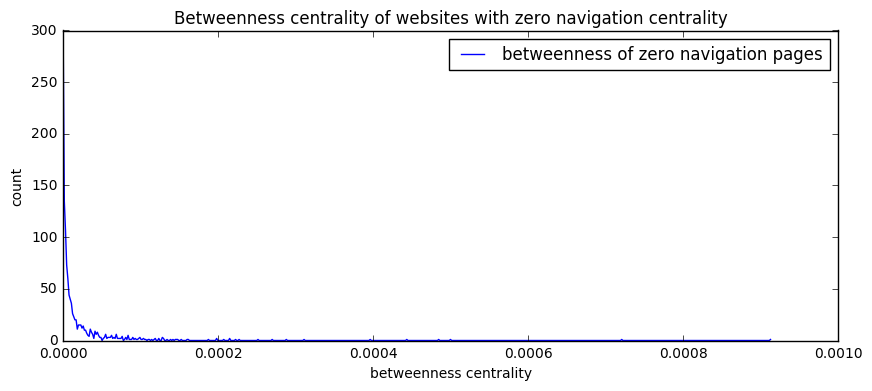

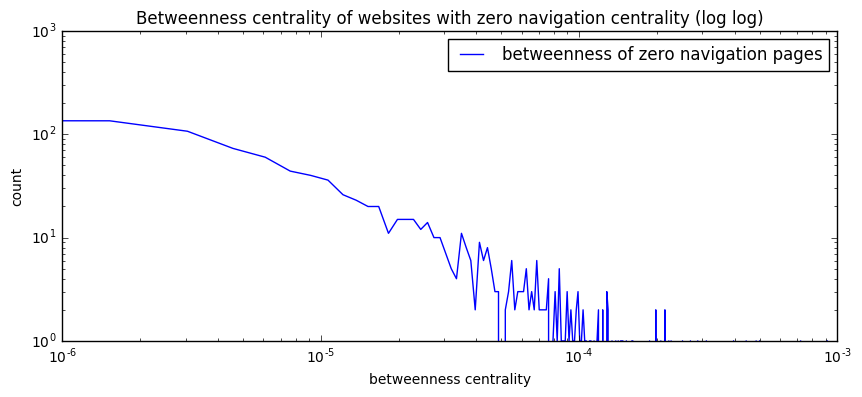

In [440]:
navigationZero_betweenness_values = [value for webpage,value in navigationZero_betweenness]

bins = 600
x,y = np.histogram(navigationZero_betweenness_values, bins)

plt.figure(figsize=(10,4))
plt.plot(y[:-1],x)
plt.title("Betweenness centrality of websites with zero navigation centrality")
plt.xlabel("betweenness centrality")
plt.ylabel("count")
plt.legend(["betweenness of zero navigation pages"])
plt.show()


plt.figure(figsize=(10,4))
plt.plot(y[:-1],x)
plt.xscale("log")
plt.yscale("log")
plt.title("Betweenness centrality of websites with zero navigation centrality (log log)")
plt.xlabel("betweenness centrality")
plt.ylabel("count")
plt.legend(["betweenness of zero navigation pages"])
plt.show()

- It can be seen on the figures that the distribution seems to follow the power law distribution. This is a representation of so called "80-20" for Paretor distribution where a vast majority of the betweenness centrality values falls within a small interval of values. 
- This reveals that most of the pages that people do not click on have low betweenness centrality. Most of the pages are in few shortest path between some source/target pairs.
- This again shows us how smart most people are in finding pages that can be considered as hubs in the network.

** Now, let's throw out all pages with zero navigation centrality and compare navigation and betweenness centrality for the remaining pages.**

    - What is the correlation between betweenness centrality and navigation centrality?
    - Comment on the top 5 outliers.


In [444]:
# Start by throwing out all pages with zero navigation centrality
navigationZero_betweenness_names = [webpage for webpage,value in navigationZero_betweenness]

# Now we want to get the data on the form (navigation value,betweenness value) 
# for each webpage that is not in navigationZero_betweenness_names
centrality_values = []

# We loop through the keys 
for website,_ in betweenness_sorted:
    if website not in navigationZero_betweenness_names:
        centrality_values.append(
            (
                navigation[website],
                betweenness[website]
            )
        )

Now we have the data on a format which allows us to evaluate the correlation quite easily. To evaluate the correlation we will do two things
    - plot up navigation centrality value vs betweenness centrality value for each webpage
    - calculate the correlation between the two centrality methods using the np module

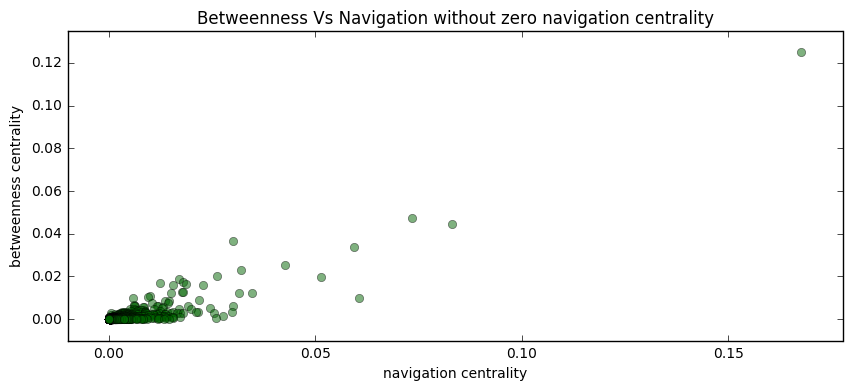

In [447]:
# We start by creating the navigation centrality value vs betweenness centrality value plot

x = range(0,len(betweenness_sorted))
navigation_reduced_values, betweenness_reduced_values = zip(*centrality_values)

plt.figure(figsize=(10,4))
plt.plot(navigation_reduced_values, betweenness_reduced_values, "o", color="darkgreen", alpha=0.5)
plt.title("Betweenness Vs Navigation without zero navigation centrality")
plt.xlabel("navigation centrality")
plt.xlim(-0.01,max(navigation_reduced_values)+0.01)
plt.ylim(-0.01,max(betweenness_reduced_values)+0.01)
plt.ylabel("betweenness centrality")
plt.show()

Now we calculate the correlation between the two centrality methods without zero navigation centrality

In [448]:
np.corrcoef(navigation_reduced_values, betweenness_reduced_values)

array([[ 1.        ,  0.88920305],
       [ 0.88920305,  1.        ]])

** Correlation conclusion**

The correlation between betweenness centrality and navigation centrality is 0.889203 and therefore we can conclude that the two centrality methods are highly correlated. This is also trivial to see in the Betweenness Vs Navigation plot. 

** Comment on the top 5 outliers. **

In [452]:
# First we need to find the top 5 outliers. We do that by going through all webpages in the dataset
# For each webpage we add together the betweenness value and the navigation value. 
# We then simply sort the result and find the 5 highest websites

centrality_added = defaultdict(float)
for webpage in betweenness:
    centrality_added[webpage] = navigation[webpage]  betweenness[webpage] 
    
centrality_added_sorted = sorted(centrality_added.items(), key = operator.itemgetter(1), reverse=True)

print ("The top 5 outliers are: \n ")


print ("{webpage_s: <26} {navigation_s: <14} {betweenness_s: <14}".format(
    webpage_s = "Webpage",navigation_s = "Navigation", betweenness_s = "Betweenness"))

print ("-----------------------------------------------------")


for website,_ in centrality_added_sorted[:5]:
    print ("{webpage_s: <26} {navigation_s: <14} {betweenness_s: <14}".format(
            webpage_s =  website,
            navigation_s = round_sig(navigation[website],5), 
            betweenness_s = round_sig(betweenness[website],5)
        ))

The top 5 outliers are: 
 
Webpage                    Navigation     Betweenness   
-----------------------------------------------------
United_States              0.16766        0.12522       
Europe                     0.083012       0.044658      
United_Kingdom             0.073327       0.047387      
England                    0.059472       0.033597      
Africa                     0.051347       0.019848      


## IIc: Bringing the text into the picture

### Exercises

In [ ]:
# Calculating the TF_IDF with the sci kit learn

# Get all websites name in an sorted array
website_names = sorted(G.nodes())

# Create a dictionary representation of the array to make the lookup simpler
website_names_dict = defaultdict(int)
for index,website in enumerate(website_names):
    website_names_dict[website] = index

article_fileuri = "/Users/GretarAtli/Dropbox/Dtu/Social_graphs_and_interactions/plaintext_articles/"

files= []

for website in website_names:
    files_path = folder_uri + website + ".txt"
    files.append(files_path)
    #print (files_path)
    
        
vectorizer = TfidfVectorizer(input = 'filename', analyzer='word', min_df = 0, stop_words = 'english')
TF_IDF_matrix = vectorizer.fit_transform(files).todense()

**Calculate the average similarity for all human navigation paths (the source/target pairs from above). Calculate mean/variance of these average similarities.**

Note that spatial.distance.cosine computes the distance, and not the similarity. So, you must subtract the value from 1 to get the similarity.

In [ ]:
def avg_similarity(path):
    path_similarity = []
    for index, website in enumerate(path):
        TF_IDF_array1 = np.array(TF_IDF_matrix[website_names_dict[path[index]]])[0]
        TF_IDF_array2 = np.array(TF_IDF_matrix[website_names_dict[path[index + 1]]])[0]

        path_similarity.append(1 - spatial.distance.cosine(TF_IDF_array1, TF_IDF_array2)) 

        # break the loop when we have processed all pairs of the path
        if index + 1 == len(path) - 1:
            break
                
    return np.mean(path_similarity)

human_paths_mean = []
shortest_paths_mean = []
# We start off by getting all of the human navigation paths (source/target) into an array
for path in paths:
    # if the line is just a single website then it is not a path and it is skipped
    if len(path) > 2:
        # calculate the human path simularity
        human_similarity = avg_similarity(path)
        human_paths_mean.append(human_similarity)  
        
        # calculate the simularity of the best path between the source and target
        source = path[0]
        target = path[-1]
        shortest_path = nx.shortest_path(G,source=source, target=target)
        shortest_similarity = avg_similarity(shortest_path)
        shortest_paths_mean.append(shortest_similarity)
            

In [ ]:
print("The mean of the human paths similarities is:       {}".format(np.mean(human_paths_mean)))
print("The average of the human paths similarities is:    {}".format(np.var(human_paths_mean)))

** Calculate the average pairwise similarity for all shortest paths between the source/target pairs (Si,j Si,j). Calculate mean/variance of the Si,j.**

In [ ]:
# Print out the result for shortest paths similarity means

print("The mean of the shortest paths similarities is:       {}".format(np.mean(shortest_paths_mean)))
print("The average of the shortest paths similarities is:    {}".format(np.var(shortest_paths_mean)))

In [ ]:

plt.figure(figsize=(10,4))
y,binEdges=np.histogram(human_paths_mean,bins = 100)
plt.plot(binEdges[:-1],y, color="blue")

y,binEdges=np.histogram(shortest_paths_mean,bins = 100)
plt.plot(binEdges[:-1],y, color="green")

plt.ylim(0, max(y)*1.3)
plt.title("Paths Similarity")
plt.xlabel("average cosine similarity of tf-idf")
plt.ylabel("count")
plt.legend(["human","shortest"])

plt.show()

**Finally, for each source/target pair, compare the human-navigation average similarity with the betweenness based average similarity, testing what fraction of the time, the average similarity is lower in the case of human navigation.**

In [ ]:
# Finally let's calculate the fraction of the time, the average similarity is lower in the case of human navigation.

human_higher = 0

for index,_ in enumerate(human_paths_mean):
    if human_paths_mean[index] > shortest_paths_mean[index]:
        human_higher += 1
    
print("The human-navigation average similarity is higher in {} out of {} times, that is {}% of the paths".format(
    human_higher,
    len(human_paths_mean),
    round_sig ( human_higher / len(human_paths_mean) * 100,6)
))